# Intro:

This notebook is the third in the series for the Capstone Project.  "Capstone_Data-Prep" covers pulling in several
data sources, trimming to the needed observations/variables, joining together, and producing the source data or this
notebook.

The second notebook "Capstone_LS_Model" covers the majority of feature selection.

In [687]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
import json
import math
import statsmodels.formula.api as smf

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

#sklearn Data Prep:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#sklearn Imputer:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# SkLearn Measurement Libraries:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# SkLearn Models

from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble


# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [688]:
# Set Paths
path = os.getcwd()
sourceDataPath = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/CleanData/'
exportPath = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/'
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/'

# set plot export paths:

print(f"Source Data:",sourceDataPath)
print(f"Exports:",exportPath)
print(f"Plots:",plotLoc)

Source Data: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/CleanData/
Exports: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/
Plots: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/


# Reusable Functions:

In [689]:
#statRow = []
cleanActionsDF = pd.DataFrame(columns = ['DF','ActionDesc','List-of-Cols','ResultShape'])

def cleanActionsReport (df,df_name,actionDesc, cols):
    # Collect Stats
    row =[]
    actionDesc = actionDesc
    listCols = cols
    resultShape = df.shape
    # Collect Results
    row = [df_name,actionDesc, listCols, resultShape]
    # append stats to Summary Stats DF
    df = cleanActionsDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [690]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per",
                                             "Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [691]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test



In [692]:
# Create DF To Hold Summary Stats
statRow = []
quantStats = pd.DataFrame(columns = ["Model","RegType","R2_Score","MSE","RMSE"])

def summaryStats_quant(model,y_test,y_pred,SummaryDF):
    regType = model
    row =[]
    Score = round(r2_score(y_test,y_pred),4)
    MSE = round(mean_squared_error(y_test,y_pred),4)
    RMSE = np.sqrt(MSE)
    # Append to Summary DF
    df = SummaryDF
    row = [model,regType,Score,MSE,RMSE]
    df_length = len(df)
    df.loc[df_length] = row
    return Score, MSE, RMSE

In [693]:
def prepVarsForMLR(df, dependent_var,*varsToRemove):
    columns = list(df.columns.values)
    columns.remove(dependent_var)
    for col in varsToRemove:
        columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(columns)

In [694]:
#guide: https://towardsdatascience.com/backward-elimination-for-feature-selection-in-machine-learning-c6a3a8f8cef4
# TODO: Add F_Stastic
# Take P_Value of the F-static

def backwardElimination(df,respVar,signLevel):
    origFeatList = df.columns.values.tolist()
    origFeatList.remove(respVar)
    # Create df for significant features:
    signFeatDF = pd.DataFrame(columns = ['feature','pvalue'])
    ##### Start Loop ########
    x = df.shape[1]
    while x > 0:
        tempdf = df
        # For feature in list of features get p
        listofVars = prepVarsForMLR(tempdf,respVar) # Prep Vars for OLS p-value:
        ols = smf.ols(formula=listofVars, data=df).fit() # fit model
        # get pvalues
        ## Make DF w/ P Values
        pvalueDF = pd.DataFrame(ols.pvalues).reset_index()
        pvalueDF = pvalueDF.rename(columns={'index':'feature',0:'pvalue'})
        pvalueDF = pvalueDF.iloc[1: , :] ## Drop first Row which is always the intercept
        ## Select Feature w/ Highest P-Value
        checkmaxP = pvalueDF['pvalue'].max()
        ## If PValue is greater that Sign-Level
        if checkmaxP >= signLevel:
            # Add Feature/PValue to SignFeatureDF
            maxP = pvalueDF[pvalueDF.pvalue == pvalueDF.pvalue.max()]
            signFeatDF = pd.concat([signFeatDF,maxP], ignore_index=True)
           # # Remove Feature From DF
            varToRemove = maxP['feature'].values.tolist() #get feature name as a string to remove
            df = df.drop(columns=varToRemove)
            ## Update x
            x=x-1
        else:
            x=0
            nonsignFeatList = pvalueDF['feature'].values.tolist()
    return signFeatDF, nonsignFeatList


In [695]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [696]:
def quickModelComparison_quant(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    for model in models:
        # Model Name
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test)
        # summary
        quantStats = summaryStats_quant(model_name, qe_y_test, y_pred_qe,qe_summaryDF)
    return qe_summaryDF

In [697]:
def z_score(df,scaleList):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in scaleList:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = round(df_std[column],5)
    return df_std

# Get & Prep Data

In [698]:
## Get Data from after LS_Modeling Feature Selection + Imputing + Scaling
file = 'Clean_Modeling_Data.xlsx'
ModelingDF_orig = pd.read_excel(sourceDataPath+file)
ModelingDF_orig = ModelingDF_orig.drop(columns=['Unnamed: 0'])
ModelingDF_orig = ModelingDF_orig.rename(columns={'SettlementAmount':'severity'})
ModelingDF_orig = ModelingDF_orig.set_index('gvkey')

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Original Shape"
df_name = "ModelingDF_orig"
cols = "All"
cleanActionsReport(ModelingDF_orig,df_name,cleanActionsDesc,cols)

print(ModelingDF_orig.shape)
ModelingDF_orig.sample(3)

(348, 160)


,exesign,src,auop,aoloch,aoloch_std,at,at_std,bkvlps,bkvlps_std,caps,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
12151,1,5,1,-0.12035,0.24778,-0.00162,-0.21427,-0.07862,-0.07691,0.12876,...,0.07,-0.12927,-0.1292,-0.29550,-0.21821,-0.13339,-0.14986,0,1,NaN
1408,1,8,1,-0.42531,0.12443,0.10983,0.83463,-0.07843,-0.07688,-0.01937,...,0.89,-0.12927,-0.1292,5.02489,3.53195,-0.12050,-0.14987,4,0,NaN
14309,1,5,1,-0.04833,-0.05180,-0.30772,-0.30554,-0.07857,-0.07690,-0.20712,...,0.32,-0.12927,-0.1292,-0.26173,-0.18073,-0.11842,-0.14408,6,0,NaN


In [699]:
# Create Working Copy of ModelingDF -- Will need to go back to this to get BBC
ModelingDF = ModelingDF_orig.copy()

In [700]:
ModelingDF['lawsuit'].value_counts()

0    302
1     46
Name: lawsuit, dtype: int64

In [701]:
## Drop Rows Where Settle Amount is Null
print(f"Count of Null Settlements:",ModelingDF['severity'].isna().sum(),"-- Original Shape:",ModelingDF.shape)
ModelingDF = ModelingDF[ModelingDF['lawsuit']==1]
print(f"Count of Null Settlements:",ModelingDF['severity'].isna().sum(),"-- Remaining Shape:",ModelingDF.shape)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Rows w/ Null Settlement"
df_name = "ModelingDF"
cols = "All"
cleanActionsReport(ModelingDF,df_name,cleanActionsDesc,cols)

print(ModelingDF.shape)

Count of Null Settlements: 337 -- Original Shape: (348, 160)
Count of Null Settlements: 35 -- Remaining Shape: (46, 160)
(46, 160)


In [702]:
# Once DF is trimmed to just companies who have been sued -- fill null severity w/ 0
ModelingDF['severity'] = ModelingDF['severity'].fillna(0)

In [703]:
nullAnalysisDF = nullAnalysis(ModelingDF)
nullAnalysisDF

Count of Variables: 160
Count of Variables without nulls: 160
Count of Variables with null : 0


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type


In [704]:
ModelingDF['severity'].describe(percentiles=[.25, .5, .75,.8,.9,.95,.99]).apply(lambda x: format(x, 'f'))

count          46.000000
mean      2334782.608696
std       7419380.548905
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
80%       2200000.000000
90%       6375000.000000
95%      10500000.000000
99%      31187500.000000
max      47500000.000000
Name: severity, dtype: object

In [705]:
ModelingDF['severity'].value_counts()

0.0           35
2200000.0      1
2700000.0      1
6000000.0      1
47500000.0     1
1500000.0      1
6750000.0      1
5750000.0      1
3750000.0      1
11250000.0     1
11000000.0     1
9000000.0      1
Name: severity, dtype: int64

In [706]:
standDev = ModelingDF['severity'].std()
mean = ModelingDF['severity'].mean()
print(f"mean:",mean)
print(f"std:",standDev)

mean: 2334782.6086956523
std: 7419380.548904913


In [707]:
# orig value calculator
zScore = 0.621289
origVal = round(mean +(zScore*standDev),1)
print(f"orig value:",origVal)

orig value: 6944362.1


In [708]:
# Scale Data -- Create List for Scaling

## Remove exceptions from scale list
scaleList = ['severity']

# Scale Data -- Call the z_score function
ModelingDF = z_score(ModelingDF,scaleList)
ModelingDF.sample(3)


,exesign,src,auop,aoloch,aoloch_std,at,at_std,bkvlps,bkvlps_std,caps,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
3362,0,88,2,-0.02302,-0.28130,0.27263,2.06916,-0.07856,-0.07691,-0.01431,...,0.16,-0.12927,-0.1292,0.64052,0.08375,-0.12893,-0.15237,5,1,-0.31469
184526,1,5,1,-0.03966,-0.38714,-0.33268,-0.35453,-0.07862,-0.07690,-0.15730,...,0.97,-0.12927,-0.1292,-0.29814,-0.22835,-0.13273,-0.12431,0,1,-0.31469
14503,1,5,2,-0.14342,-0.39321,-0.31158,-0.36348,-0.07853,-0.07689,-0.21913,...,0.44,-0.12927,-0.1292,-0.11740,-0.21820,-0.13564,-0.11885,3,1,-0.31469


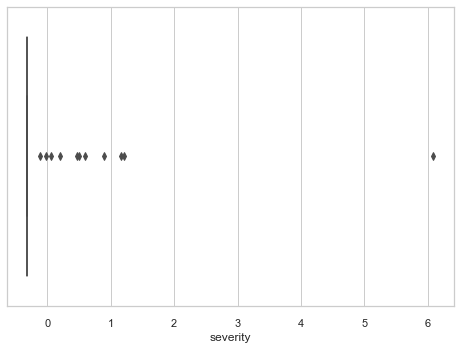

In [709]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=ModelingDF['severity'])

## LawSuit Modeling -- Feature Selection and Prepare Data

Process:
* Check Correlation w/ Response Var
* TODO: Check Collinearity
* Use RF/GB Feature Importance
* Create Resulting Feature List

### LawSuit Modeling -- Feature Selection -- Check Correlation

In [710]:
# Feature Selection -- Check Correlation -- Correlation with output variable
responseVar = 'severity'
cor = round(ModelingDF.corr(),3)
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
nonRelevant_features = cor_target[cor_target<0.05] # Look for Features w/ less 0.05 cor
nonRelevant_features

exesign           0.038
src               0.010
aoloch            0.020
chech             0.047
cshpri_std        0.042
epsfi_std         0.020
epsfx_std         0.027
epspi_std         0.020
esopct            0.047
esopct_std        0.046
msa               0.048
msa_std           0.043
pnca              0.016
pstk              0.023
siv               0.010
siv_std           0.049
sppiv             0.046
tstk_std          0.044
wcap              0.008
st_per_growth     0.018
st_volatility     0.039
sec_trfm_std      0.008
sec_trt1m_mean    0.004
sec_trt1m_std     0.045
rat_spcsrc        0.028
Name: severity, dtype: float64

In [711]:
## Feature Selection -- Check Correlation -- Trim DF to Relevant Features

# List of features to drop
nonRelevant_features = nonRelevant_features.index.values.tolist()
# Override
overrideCols = ['st_per_growth','rat_spcsrc']
for col in overrideCols:
    nonRelevant_features.remove(col)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features with less than 0.05 corr while making sure to have 1 feature per source"
df_name = "ModelingDF"

ModelingDF = ModelingDF.drop(columns=nonRelevant_features)
cleanActionsReport(ModelingDF,df_name,cleanActionsDesc,nonRelevant_features)

# Resulting DF
print(ModelingDF.shape)
ModelingDF.sample(3)


(46, 137)


,auop,aoloch_std,at,at_std,bkvlps,bkvlps_std,caps,caps_std,capx,capx_std,...,st_prc_end,st_per_growth,st_per_currentToMax,st_per_lowToStart,sec_ajexm,sec_ajpm,sec_trfm_mean,rat_spcsrc,lawsuit,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
12978,1,3.49974,0.82628,0.13355,-0.07859,-0.07690,0.76753,0.02969,0.22587,0.31838,...,0.09383,0.33,0.98,-0.07,-0.12927,-0.1292,-0.28916,0,1,-0.31469
14868,1,-0.36865,-0.32126,-0.36691,-0.07872,-0.07685,-0.21913,0.09894,-0.22955,-0.32022,...,-0.19363,-0.64,0.22,-0.68,-0.12927,-0.1292,-0.29814,0,1,-0.31469
65105,1,-0.31241,-0.22163,-0.32406,-0.07850,-0.07691,-0.16603,-0.15040,-0.07311,-0.37912,...,0.04791,0.57,0.98,-0.01,-0.12927,-0.1292,-0.29814,4,1,-0.31469


###  Severity Modeling -- Feature Selection -- Use Rand Forest Regressor Feature Importance
* Creates a Test/Train Split (Will Resplit from Source After Feature Selection)
* Then uses Random Forest and Grad Boost for Feature Importance
* Results reflected in feature lists for model and stored as reports
and plots in the export directory

In [712]:
# Set or Reset Test/Train Split
# Params
df=ModelingDF
ResponseVar = 'severity'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)


x_train shape: (36, 136)
x_test shape: (10, 136)


In [713]:
print("starting RF")
# Random Forest
## Set and Fit Model
## Note: Params from gridSearchCV optimized for recall w/ all features
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


In [714]:
# Multiple Regression -- Call Summary Function

regType = "RF Regressor -- Feature Selection"
stats_y_test = y_test
stats_y_pred = y_pred_rf
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
print(f'r2 score is: ',Score)
print(f'mean_sqrd_error:',MSE)
print(f'root_mean_squared error:',RMSE)



r2 score is:  -3.4184
mean_sqrd_error: 1.6585
root_mean_squared error: 1.287827628217379


Start RF Feature Importance


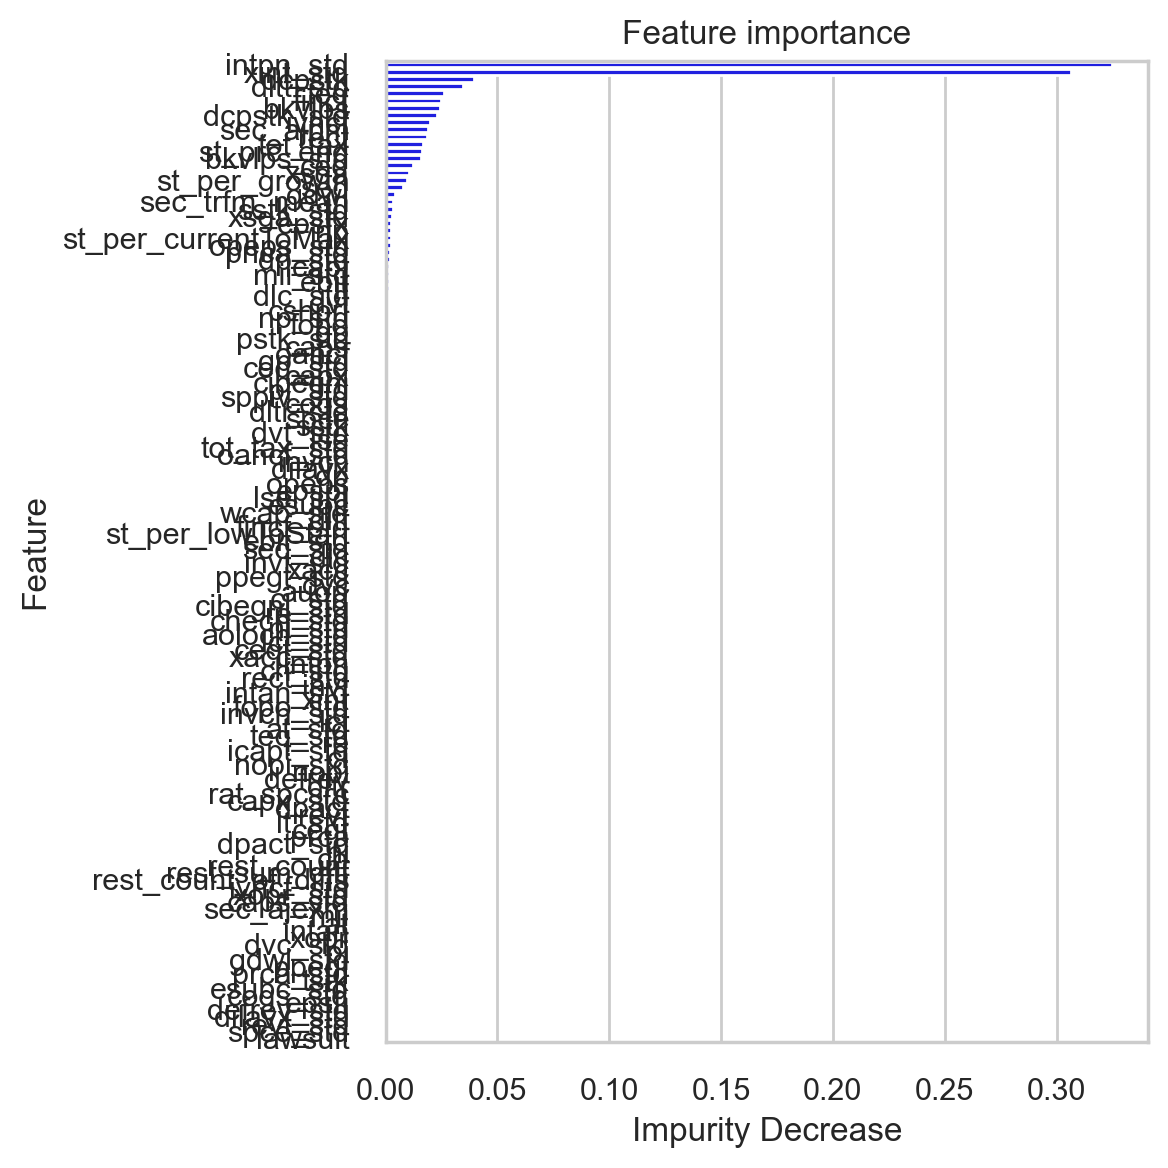

In [715]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Severity_FeatSelect.png')


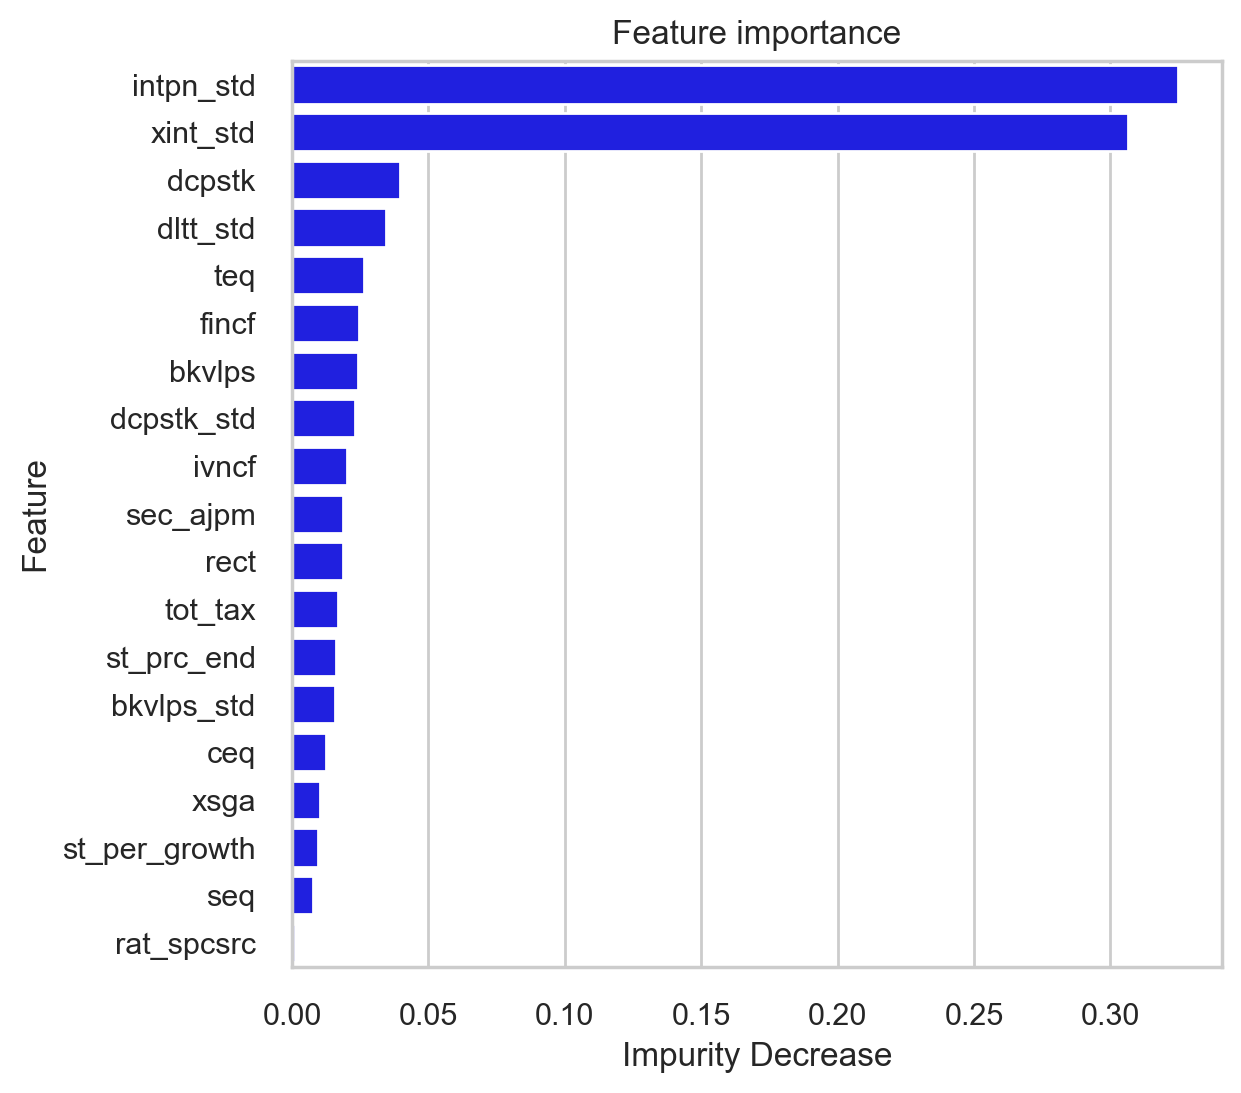

In [716]:
# drop these row indexes
# from dataFrame
index_names = feature_importances[feature_importances['impDecrease'] <= 0.005 ].index

# drop these row indexes
# from dataFrame
feature_importances.drop(index_names, inplace = True)
feature_importances

featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
feature_importances = feature_importances.append(featImport_ManAppend,ignore_index=True)

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature",
                  data=feature_importances, color="blue")
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined_LS_FeatSelect.png')


In [717]:
# Feature Selection -- make list of features
selectedFeatures = feature_importances.copy()
selectedFeatures = selectedFeatures.drop(columns=['impDecrease','Model'])
selectedFeatures = selectedFeatures['feature'].unique()
selectedFeatures

array(['intpn_std', 'xint_std', 'dcpstk', 'dltt_std', 'teq', 'fincf',
       'bkvlps', 'dcpstk_std', 'ivncf', 'sec_ajpm', 'rect', 'tot_tax',
       'st_prc_end', 'bkvlps_std', 'ceq', 'xsga', 'st_per_growth', 'seq',
       'rat_spcsrc'], dtype=object)

In [718]:
# Create Modeling Dataframe for Modeling Lawsuit

# New Feature List (From Re-Run of Feature Import using Recall settings, only used RF Features since Recall was better)
## Feature List Exported as ..."RFONLY"
## Manuall removed features that had multiple versions -- and commented out section below that did that for orig list
sev_featList = ['severity',
               'intpn_std', 'xint_std', 'ivncf', 'st_prc_end', 'dcpstk','dltt_std', 'teq',
               'ebit', 'rect', 'tot_tax', 'seq','epsfi', 'mii_std', 'xsga_std', 'gp', 'epsfx',
               'bkvlps','spce', 'rest_count', 'dp_std', 'epspi', 'cibegni', 'esubc',
               'rat_spcsrc'# manual addition
               ]

## Create Modeling Dataframe
sev_Modeling = ModelingDF[sev_featList]
## Set gvkey as index
print(sev_Modeling.shape)
sev_Modeling.sample(3)

(46, 25)


,severity,intpn_std,xint_std,ivncf,st_prc_end,dcpstk,dltt_std,teq,ebit,rect,...,gp,epsfx,bkvlps,spce,rest_count,dp_std,epspi,cibegni,esubc,rat_spcsrc
gvkey,,,,,,,,,,,,,,,,,,,,,
14033,-0.31469,-0.250250,-0.31235,0.29437,-0.15818,-0.191190,-0.39879,-0.29504,-0.29760,-0.32888,...,-0.28667,-0.07446,-0.078620,-0.289870,3,-0.37246,-0.07455,-0.28047,0.16151,0
105104,-0.31469,0.094819,-0.26912,-0.85955,-0.08954,-0.191190,-0.21317,0.95530,0.63081,0.20187,...,0.54022,-0.06501,-0.078610,0.744480,0,0.99424,-0.06478,0.68956,0.16151,0
20327,0.46031,-0.329010,-0.36621,0.29545,-0.14037,0.100461,-0.40195,-0.30573,-0.31434,-0.37266,...,-0.29351,-0.07772,-0.127353,-0.273648,0,-0.37382,-0.07780,-0.28778,0.16151,0


In [719]:
# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features with less than 0.05 impDecrease"
df_name = "sev_Modeling"
remainingCols = sev_featList
cleanActionsReport(sev_Modeling,df_name,cleanActionsDesc,remainingCols)

,DF,ActionDesc,List-of-Cols,ResultShape
0,ModelingDF_orig,Original Shape,All,"(348, 160)"
1,ModelingDF,Drop Rows w/ Null Settlement,All,"(46, 160)"
2,ModelingDF,Drop Features with less than 0.05 corr while m...,"[exesign, src, aoloch, chech, cshpri_std, epsf...","(46, 137)"
3,sev_Modeling,Drop Features with less than 0.05 impDecrease,"[severity, intpn_std, xint_std, ivncf, st_prc_...","(46, 25)"


###  Severity Modeling -- Feature Selection -- Best Subset Selection

In [720]:
#Multiple Regression -- Check Correlations in HeatMap
plt.figure(figsize=(12,10))
cor = round(sev_Modeling.corr(),3)


<Figure size 864x720 with 0 Axes>

In [721]:
#Multiple Regressions -- Correlation with output variable
responseVar = 'severity'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.05] # Look for Features w/ greater 0.05 cor
relevant_features

severity      1.000
intpn_std     0.122
xint_std      0.104
ivncf         0.082
st_prc_end    0.108
dcpstk        0.147
dltt_std      0.123
teq           0.097
ebit          0.089
rect          0.111
tot_tax       0.089
seq           0.098
epsfi         0.110
mii_std       0.070
xsga_std      0.114
gp            0.090
epsfx         0.122
bkvlps        0.069
spce          0.088
rest_count    0.169
dp_std        0.116
epspi         0.106
cibegni       0.086
esubc         0.068
Name: severity, dtype: float64

In [722]:
# Multiple Regressions -- Trim DF to Relevant Features
relFeatList = relevant_features.index.values.tolist()
sev_Modeling = sev_Modeling[relFeatList]
sev_Modeling.sample(3)

,severity,intpn_std,xint_std,ivncf,st_prc_end,dcpstk,dltt_std,teq,ebit,rect,...,xsga_std,gp,epsfx,bkvlps,spce,rest_count,dp_std,epspi,cibegni,esubc
gvkey,,,,,,,,,,,,,,,,,,,,,
12756,-0.31469,-0.073290,-0.002880,-0.08890,0.03233,-0.19119,0.463690,0.03417,0.10998,0.68923,...,-0.00706,0.05551,-0.03676,-0.07858,0.12805,4,0.140700,-0.03569,0.10562,0.16151
3362,-0.31469,1.123469,1.013050,-0.24446,-0.06301,-0.19119,3.821930,0.28067,0.23545,0.29289,...,-0.00252,0.10257,-0.04936,-0.07856,0.15418,1,1.472620,-0.05029,0.15426,0.00786
61205,-0.31469,-0.137738,-0.206791,0.24872,-0.22682,-0.19119,0.011657,-0.28659,-0.30011,-0.35943,...,-0.14176,-0.28264,-0.03949,-0.07858,-0.27460,0,-0.199334,-0.03957,-0.26849,0.16151


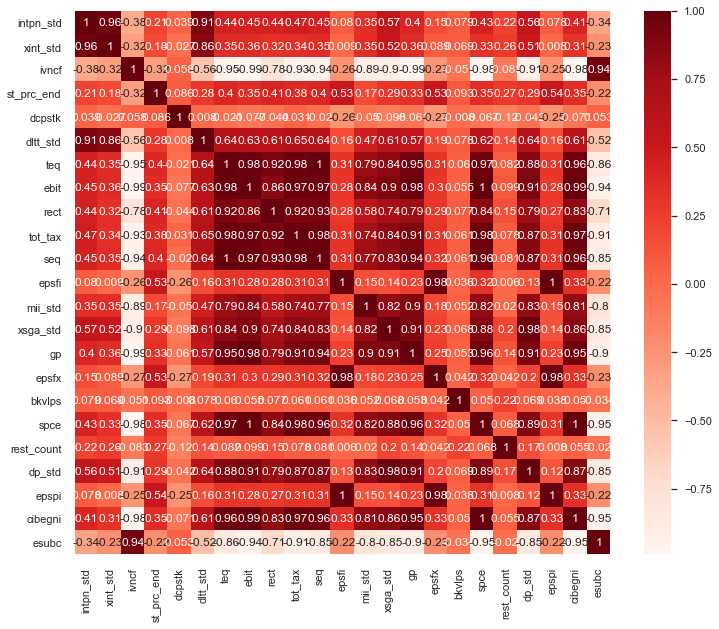

In [723]:
# Multiple Regressions -- Check for Correlations of Relevant Features Against Each
## Need to identify any collinear features
## Since many variables on this list are dummy variables, and corral is a subset of wave, I don't
### need to check for collinearity among those, just need to with age.
tempCLCheck = sev_Modeling.drop(columns=['severity'])

plt.figure(figsize=(12,10))
cor = round(tempCLCheck.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.savefig(plotLoc+'Collinear-Heatmap.png')

In [724]:
# Drop Highly Collinear Features
colsToDrop = ['teq', # collinear w/ seq
              'xint_std', #collinear w/ intpn_std
              'cibegni', # many collinearities
              'spce', # many collinearities
              'mii_std', # many collinearties esp. gp
              'tot_tax', # many collinearties esp. gp
              'ebit', # many collinearties esp. gp
              'epspi', 'epsfx', #highly collinear w/ epsfi
              'ivncf', # highly collinear w/ many
              'dp_std', # highly collinear w/ many
            ]

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Collinear Features"
df_name = "sev_Modeling"

sev_Modeling = sev_Modeling.drop(columns=colsToDrop)
cleanActionsReport(sev_Modeling,df_name,cleanActionsDesc,colsToDrop)

,DF,ActionDesc,List-of-Cols,ResultShape
0,ModelingDF_orig,Original Shape,All,"(348, 160)"
1,ModelingDF,Drop Rows w/ Null Settlement,All,"(46, 160)"
2,ModelingDF,Drop Features with less than 0.05 corr while m...,"[exesign, src, aoloch, chech, cshpri_std, epsf...","(46, 137)"
3,sev_Modeling,Drop Features with less than 0.05 impDecrease,"[severity, intpn_std, xint_std, ivncf, st_prc_...","(46, 25)"
4,sev_Modeling,Drop Collinear Features,"[teq, xint_std, cibegni, spce, mii_std, tot_ta...","(46, 13)"


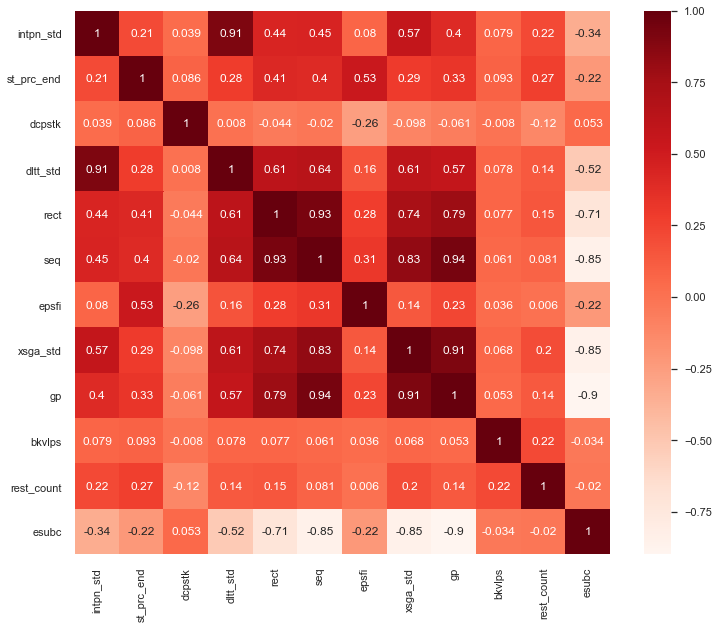

In [725]:
# Re-Check Collinearity
## Need to identify any collinear features
## Since many variables on this list are dummy variables, and corral is a subset of wave, I don't
### need to check for collinearity among those, just need to with age.
tempCLCheck = sev_Modeling.drop(columns=['severity'])

plt.figure(figsize=(12,10))
cor = round(tempCLCheck.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.savefig(plotLoc+'Collinear-Heatmap_re-check.png')


###  Severity Modeling -- Feature Selection -- Clean-Up -- Rename Variables

In [726]:
sev_Modeling = sev_Modeling.rename(columns={'st_prc_end':'Stock-End-Price',
                                            'rect':'Receivables(SD)',
                                            'seq':'Stockholders-Equity-Parent',
                                            'gp':'Gross-Profit',
                                            'rest_count':'Number-Of-Restatements',
                                            'xsga':'Administrative-Expense(SD)',
                                            'epsfi':'Earnings-Share-Diluted',
                                            'intpn_std':"Interest-Paid(SD)",
                                            'dcpstk':'Convertible-Debt_Pref-Stock',
                                            'dltt_std':'Long-Term-Debt(SD)',
                                            'xsga_std':'Administrative-Expense',
                                            'bkvlps':'Book-Value-Per-Share',
                                            'esubc':'Equity-in-Net-Loss',
                                            })

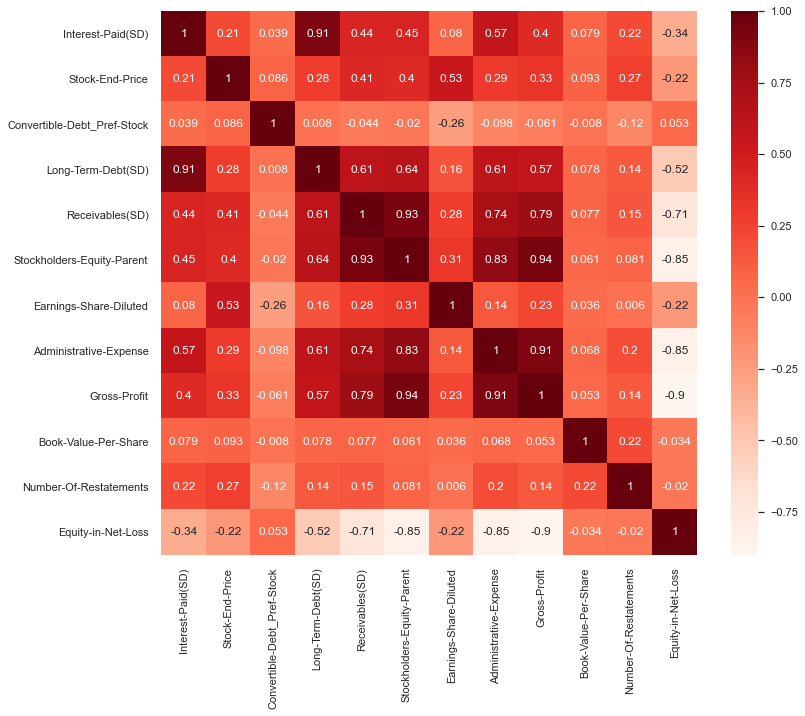

In [727]:
# Re-Check Collinearity
## Need to identify any collinear features
tempCLCheck = sev_Modeling.drop(columns=['severity'])

plt.figure(figsize=(12,10))
cor = round(tempCLCheck.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.savefig(plotLoc+'Collinear-Heatmap_re-check.png')

# Severity Modeling -- Modeling -- Initial Model Evaluation

In [728]:
# Multiple Regression -- Set or Reset Test/Train Split
# Params
df=sev_Modeling
ResponseVar = 'severity'
PredictorVar = df.columns.values.tolist()
PredictorVar.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar, ResponseVar)


,Interest-Paid(SD),Stock-End-Price,Convertible-Debt_Pref-Stock,Long-Term-Debt(SD),Receivables(SD),Stockholders-Equity-Parent,Earnings-Share-Diluted,Administrative-Expense,Gross-Profit,Book-Value-Per-Share,Number-Of-Restatements,Equity-in-Net-Loss
gvkey,,,,,,,,,,,,
6574,-0.253660,-0.08057,-0.191190,-0.206520,-0.26458,-0.19893,-0.06943,-0.155540,-0.22310,-0.078560,2,0.160603
24893,0.039640,-0.02535,-0.191190,-0.082740,-0.24293,0.12133,-0.04853,0.437690,0.18686,-0.078540,3,0.161510
65105,-0.327380,0.04791,-0.191190,-0.402830,-0.27717,-0.16921,-0.04023,-0.190780,-0.14698,-0.078500,2,0.161510
14269,-0.189150,0.11907,-0.191190,0.008440,-0.30541,-0.24091,0.00619,0.134260,-0.08655,-0.078610,4,0.161510
13163,-0.325580,-0.19626,-0.191190,-0.403340,-0.35722,-0.29360,-0.09128,-0.250130,-0.28774,-0.078610,0,0.161510
12151,-0.260340,-0.13337,-0.191190,-0.165250,0.05719,-0.13484,-0.08088,-0.052340,0.04664,-0.078620,3,0.161510
184526,-0.311800,-0.20099,-0.191190,-0.389520,-0.36759,-0.29652,-0.09831,-0.261050,-0.29156,-0.078620,4,0.161510
12785,0.035440,-0.06440,-0.191190,0.146280,-0.06003,-0.18172,-0.07258,-0.240410,-0.22100,-0.078620,4,0.161510
9359,-0.017250,-0.04125,-0.191190,0.346160,0.18888,0.23983,-0.04276,1.079390,1.19697,-0.078550,3,-0.065510


## Severity Modeling -- Initial Model Evaluation -- Multiple Linear Regression

In [729]:
# Multiple Regression -- Set or Reset Test/Train Split

# Fit Mode
mr = LinearRegression()
mr.fit(x_train,y_train)

# Make Prediction
mr_yPred =  mr.predict(x_test)

In [730]:
# Multiple Regression -- Call Summary Function
# def summaryStats(regType,y_test,y_pred,SummaryDF):

regType = "Multiple-Regression-QE"
stats_y_test = y_test
stats_y_pred = mr_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741


## Severity Modeling -- Initial Model Evaluation -- Ridge Regression

In [731]:
# Ridge -- Create a set of alphas (same as lambdas) to be tested.
start = 0.01
stop = 100
alphas = np.linspace(start,stop,num=1000)

In [732]:
# Ridge -- Initialize Ridge Regression:
ridge = Ridge(normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
ridgeResults = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alphas
for a in alphas:
    alpha = a
    ridge.set_params(alpha = a)
    ridge.fit(x_train, y_train)
    coef = ridge.coef_
    coefs.append(ridge.coef_)
    pred = ridge.predict(x_test)
    MSE = round(mean_squared_error(y_test, pred),3)
    row = [alpha,MSE]
    df_length = len(ridgeResults)
    ridgeResults.loc[df_length] = row
ridgeResults.head()

,alpha,MSE
0,0.01000,1.714
1,0.11009,0.717
2,0.21018,0.639
3,0.31027,0.592
4,0.41036,0.555


In [733]:
# print row with lowest MSE
rr_results = ridgeResults.loc[ridgeResults['MSE'].idxmin()]
rr_results

alpha    3.312973
MSE      0.386000
Name: 33, dtype: float64

In [734]:
# Ridge -- Re-run w/ best alpha

# Fit Model
ridge = Ridge(normalize = True)
ridge.set_params(alpha = 3.91)
ridge.fit(x_train, y_train)

# Make Prediction
ridge_yPred =  ridge.predict(x_test)

In [735]:
# Ridge-- predicting the accuracy score
regType = "Ridge-QE"
stats_y_test = y_test
stats_y_pred = ridge_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289


### Lasso Regression

In [736]:
# Lasso Regression (using the same test/train split and alphas as Ridge Regression above)

#Initialize Lasso Regression:
lasso = Lasso(max_iter = 10000, normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
lassoResults = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alpas
for a in alphas:
    alpha = a
    lasso.set_params(alpha = a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    pred = lasso.predict(x_test)
    MSE = round(mean_squared_error(y_test, pred),3)
    row = [alpha,MSE]
    df_length = len(lassoResults)
    lassoResults.loc[df_length] = row
lassoResults.head()

,alpha,MSE
0,0.01000,0.631
1,0.11009,0.416
2,0.21018,0.416
3,0.31027,0.416
4,0.41036,0.416


In [737]:
# print row with lowest MSE
lasso_results = lassoResults.loc[lassoResults['MSE'].idxmin()]
lasso_results

alpha    0.11009
MSE      0.41600
Name: 1, dtype: float64

In [738]:
#Re-run w/ best alpha

#get best alpha as a variable
bestAlpha = round(lassoResults.loc[lassoResults['MSE'].idxmin(), 'alpha'],2)
alphas = [bestAlpha]

#Initialize Ridge Regression:
lasso = Lasso(max_iter = 10000, normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
bestLassoResult = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alphas
for a in alphas:
    alpha = a
    lasso.set_params(alpha = a)
    lasso.fit(x_train, y_train)
    lasso_yPred = lasso.predict(x_test)
    MSE = round(mean_squared_error(y_test, lasso_yPred),3)
    row = [alpha,MSE]
    df_length = len(bestLassoResult)
    bestLassoResult.loc[df_length] = row
bestLassoResult.head()

,alpha,MSE
0,0.11,0.416


In [739]:
# Lasso --  Find the coefficients reduced to zero.
pd.Series(lasso.coef_, index=x_test.columns)

Interest-Paid(SD)             -0.0
Stock-End-Price                0.0
Convertible-Debt_Pref-Stock    0.0
Long-Term-Debt(SD)            -0.0
Receivables(SD)               -0.0
Stockholders-Equity-Parent    -0.0
Earnings-Share-Diluted        -0.0
Administrative-Expense        -0.0
Gross-Profit                  -0.0
Book-Value-Per-Share          -0.0
Number-Of-Restatements        -0.0
Equity-in-Net-Loss             0.0
dtype: float64

In [740]:
# Lasso -- predicting the accuracy score
regType = "Lasso-QE"
stats_y_test = y_test
stats_y_pred = lasso_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats


,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289
3,Lasso-QE,Lasso-QE,-0.1073,0.4156,0.644670


### PLS Regression

In [741]:
# PLS - Fit Model

# PLS  -set length to length of training set
n = len(x_train)

# Set K Folds (to 10-fold) for CV
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

#Initialize MSE list
mse = []

# Calculate MSE using CV for the 13 principle components, adding one component at the time.
upper = x_train.shape[1]

for i in np.arange(1, upper):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(x_train), scale(y_train),
                                            cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(score)
mse

[21.02062396864269,
 71.30463139665213,
 77.09020168863375,
 411.2552456675897,
 537.8941222600713,
 253.2891221806301,
 102.22810936616436,
 2.9161971618616893,
 2.2570913792797374,
 19.506312866426892,
 16.443616697564686]

(-1.0, 11.5)

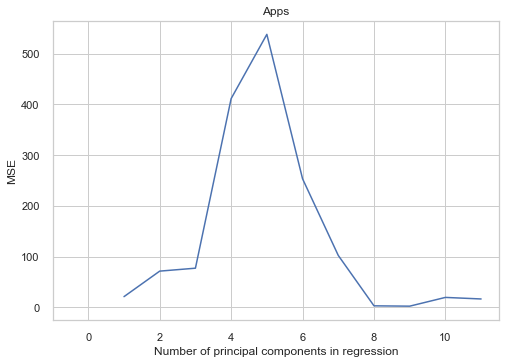

In [742]:
# PLS - Plot results
plt.plot(np.arange(1, upper), np.array(mse))
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Apps')
plt.xlim(xmin=-1)


In [743]:
# PLS -- Re-Run with the best result for M.
pls_m = 3
pls = PLSRegression(n_components=pls_m)
pls.fit(scale(x_train), y_train)

pls_yPred = pls.predict(scale(x_test))
pls_mse = round(mean_squared_error(y_test, pls_yPred),3)
bos_pls_rmse = round(math.sqrt(pls_mse),3)
print("MSE: ", bos_pls_rmse)

MSE:  0.777


In [744]:
# PLS -- predicting the accuracy score
regType = "PLS-QE"
stats_y_test = y_test
stats_y_pred = pls_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289
3,Lasso-QE,Lasso-QE,-0.1073,0.4156,0.644670
4,PLS-QE,PLS-QE,-0.6103,0.6045,0.777496


### Bagging

In [745]:
# Bagging -- Fit Model and Make Prediction:
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=1000,
                            random_state=0,max_samples=0.8)
bagging.fit(X=x_train, y=y_train)

#Make Predictions
bagging_yPred = bagging.predict(x_test)
print("done")

done


In [746]:
# Bagging -- predicting the accuracy score
regType = "Bagging-QE"
stats_y_test = y_test
stats_y_pred = bagging_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289
3,Lasso-QE,Lasso-QE,-0.1073,0.4156,0.644670
4,PLS-QE,PLS-QE,-0.6103,0.6045,0.777496
5,Bagging-QE,Bagging-QE,-3.6872,1.7594,1.326424


### Boosting

In [747]:
#Boost

# Set Params
parameters = {'learning_rate': np.linspace(0.001, 0.99, 20),'n_estimators': np.arange(1, 40, 2)}

#fit Mode - Find Best Parameters
boostedCVModel = GridSearchCV(ensemble.GradientBoostingRegressor(random_state=0),
                              parameters, n_jobs=4, cv=10)
boostedCVModel.fit(X=x_train, y=y_train.values.ravel())

# Get Best Estimator
bestEst = boostedCVModel.best_estimator_

print (boostedCVModel.best_score_, boostedCVModel.best_params_)
boost_yPred = bestEst.predict(x_test)
boostMSE = round(mean_squared_error(boost_yPred, y_test),4)
print("Test MSE is: ", boostMSE)

-0.02930779338577414 {'learning_rate': 0.20921052631578949, 'n_estimators': 15}
Test MSE is:  4.3827


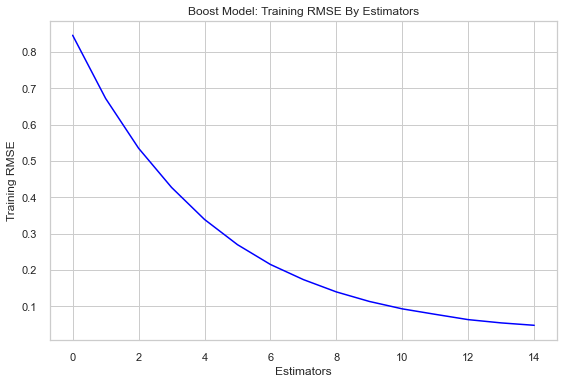

In [748]:
#Boost
BoostTrainScore = bestEst.train_score_

#Convert Array to DF
BoostTrainScore = pd.Series(BoostTrainScore)
BoostTrainScore = BoostTrainScore.to_frame().reset_index()
BoostTrainScore = BoostTrainScore.rename(columns={'index':'Estimators',0:'TrainingScore'})
BoostTrainScore = BoostTrainScore.sort_values(by='Estimators',ascending=False)
BoostTrainScore['TrainingScore'] = np.sqrt(BoostTrainScore['TrainingScore'])
BoostTrainScore

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(x="Estimators", y="TrainingScore", data=BoostTrainScore,color="blue")
ax.set_title("Boost Model: Training RMSE By Estimators")
ax.set_ylabel("Training RMSE")
fig.tight_layout()

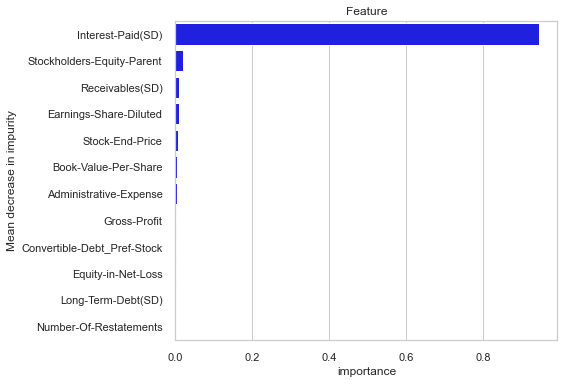

In [749]:
#Boost
feature_importances = bestEst.feature_importances_

#Convert Array to DF
PredictorVar ='severity' #TODO -- FIX
feature_importances = pd.Series(x_train.columns.tolist(),feature_importances)
feature_importances = feature_importances.to_frame().reset_index()
feature_importances = feature_importances.rename(columns={'index':'importance',0:'feature'})
feature_importances = feature_importances.sort_values(by='importance',ascending=False)
feature_importances

#plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.barplot(x="importance", y="feature", data=feature_importances,color="blue")
ax.set_title("Feature")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [750]:
# Boost -- predicting the accuracy score
regType = "Boost-QE"
stats_y_test = y_test
stats_y_pred = boost_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289
3,Lasso-QE,Lasso-QE,-0.1073,0.4156,0.644670
4,PLS-QE,PLS-QE,-0.6103,0.6045,0.777496
5,Bagging-QE,Bagging-QE,-3.6872,1.7594,1.326424
6,Boost-QE,Boost-QE,-10.6758,4.3827,2.093490


In [751]:
# Print Recap of Quantitative Stats
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289
3,Lasso-QE,Lasso-QE,-0.1073,0.4156,0.644670
4,PLS-QE,PLS-QE,-0.6103,0.6045,0.777496
5,Bagging-QE,Bagging-QE,-3.6872,1.7594,1.326424
6,Boost-QE,Boost-QE,-10.6758,4.3827,2.093490


# Severity Modeling -- Modeling -- Selected Model Improvement:  Ridge Regression


In [752]:
# Ridge -- Create a set of alphas (same as lambdas) to be tested.
start = 0.01
stop = 100
alphas = np.linspace(start,stop,num=1000)

In [753]:
# Ridge -- Initialize Ridge Regression:
ridge = Ridge(normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
ridgeResults = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alphas
for a in alphas:
    alpha = a
    ridge.set_params(alpha = a)
    ridge.fit(x_train, y_train)
    coef = ridge.coef_
    coefs.append(ridge.coef_)
    pred = ridge.predict(x_test)
    MSE = round(mean_squared_error(y_test, pred),3)
    row = [alpha,MSE]
    df_length = len(ridgeResults)
    ridgeResults.loc[df_length] = row
ridgeResults.head()

,alpha,MSE
0,0.01000,1.714
1,0.11009,0.717
2,0.21018,0.639
3,0.31027,0.592
4,0.41036,0.555


In [754]:
# print row with lowest MSE
rr_results = ridgeResults.loc[ridgeResults['MSE'].idxmin()]
rr_results

alpha    3.312973
MSE      0.386000
Name: 33, dtype: float64

In [755]:
# Ridge -- Re-run w/ best alpha

# Fit Model
ridge = Ridge(normalize = True)
ridge.set_params(alpha = 3.91)
ridge.fit(x_train, y_train)

# Make Prediction
ridge_yPred =  ridge.predict(x_test)

In [756]:
# Ridge-- predicting the accuracy score
regType = "Ridge-Selected-Model"
stats_y_test = y_test
stats_y_pred = ridge_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-3.4184,1.6585,1.287828
1,Multiple-Regression-QE,Multiple-Regression-QE,-5.3902,2.3986,1.548741
2,Ridge-QE,Ridge-QE,-0.0282,0.3860,0.621289
3,Lasso-QE,Lasso-QE,-0.1073,0.4156,0.644670
4,PLS-QE,PLS-QE,-0.6103,0.6045,0.777496
5,Bagging-QE,Bagging-QE,-3.6872,1.7594,1.326424
6,Boost-QE,Boost-QE,-10.6758,4.3827,2.093490
7,Ridge-Selected-Model,Ridge-Selected-Model,-0.0282,0.3860,0.621289
